In [2]:
import argparse
import logging
import math
import os
import random

import datasets
from datasets import load_dataset, load_metric
from torch.utils.data.dataloader import DataLoader
from tqdm.auto import tqdm

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
)
from transformers.utils.versions import require_version

# My custom model
from models import DeeBertForSequenceClassification
from models import BertConfig
import torch
import matplotlib.pyplot as plt
import numpy as np

# Test DeeBert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# change model pretrained path here
config = BertConfig(entropy_threshold=0.5)
model = DeeBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

In [ ]:
inputs = tokenizer(["Hello, my dog is cute and I am the biggest person in the world haha, Excuse me"], 
                   max_length = 128, padding='max_length', truncation=True, return_tensors="pt")
labels = torch.tensor([0]).unsqueeze(0)

In [ ]:
# first phrase
outputs = model(**inputs, labels=labels)

In [ ]:
# second phrase
outputs = model.exit_inference_forward(**inputs, labels=labels)

In [ ]:
model.stop_layers

# Test result of new idea

In [ ]:
data = [torch.cat((torch.rand((32, 1)), torch.randint(0, 2, (32, 1))), dim = 1) for _ in range(0, 12)]

In [ ]:
def accuracy(y_hat, y):
    return (y_hat == y).float().mean()

In [ ]:
search_space = torch.linspace(np.round(X.min().numpy() - 0.01, 2), np.round(X.max().numpy() + 0.01, 2), 100)

In [ ]:
search_space

In [ ]:
best_acc = 0
best_acc_idx = 0
for i, threshold in enumerate(search_space):
    predict = (X < threshold).long()
    if accuracy(predict, y) > best_acc:
        best_acc = accuracy(predict, y)
        best_acc_idx = i

In [ ]:
best_acc, search_space[best_acc_idx]

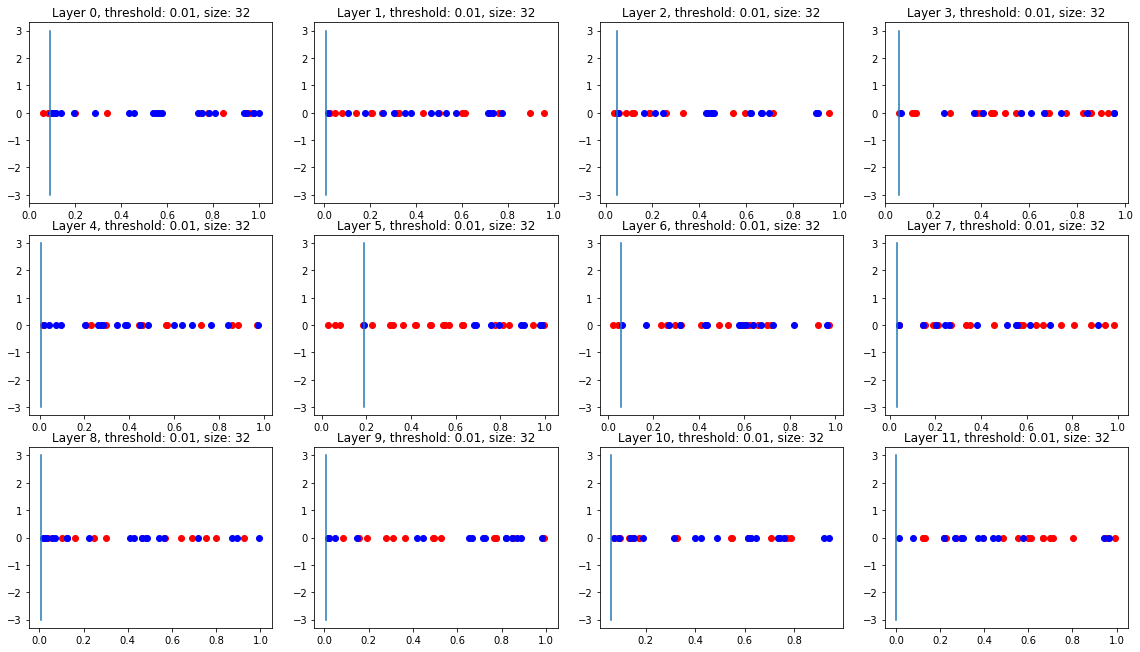

In [177]:
optimal_point = []
fig, axs = plt.subplots(3, 4, figsize=(16, 9))
fig.tight_layout()


mask = data[i][:, 0] > 0

for i in range(0, 12):
    X = data[i][:, 0][mask]
    y = data[i][:, 1][mask]
    
    best_threshold = X.min().numpy() - 0.01
    search_space = torch.linspace(np.round(X.min().numpy() - 0.01, 2), np.round(X.max().numpy() + 0.01, 2), 100)
    for j, threshold in enumerate(search_space):
        gain = (X[torch.where(y > 0)[0]] < threshold).long().sum()
        error = (X[torch.where(y < 1)[0]] < threshold).long().sum()
        if (gain - error)/(gain + error) > 0.9:
            best_threshold = threshold
    
    # thresh_hold = np.floor(X[torch.where(y < 1)[0]].min()*100)/100
    
    
    x_min, x_max = torch.floor(X.min()), torch.ceil(X.max())
    y_min, y_max = -3, 3
    yy = torch.linspace(y_min, y_max, 3)
    
    axs[int(i/4), i%4].set_title(f'Layer {i}, threshold: {thresh_hold:.2f}, size: {len(X)}')
    axs[int(i/4), i%4].scatter(X[torch.where(y > 0)[0]], torch.zeros_like(X[torch.where(y > 0)[0]]), c="red") # 1
    axs[int(i/4), i%4].scatter(X[torch.where(y < 1)[0]], torch.zeros_like(X[torch.where(y < 1)[0]]), c="blue")# 0
    axs[int(i/4), i%4].plot(best_threshold*torch.ones_like(yy), yy)
    
    mask = mask & (data[i][:, 0].masked_fill(~mask, 0.0) > thresh_hold)